In [132]:
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np

import matplotlib.pyplot as plt


In [133]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.4.0'
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 229 kB in 2s (130 kB/s)
Reading package lists... Done


In [134]:
!pip install pyspark

In [135]:
from pyspark.sql import SparkSession

In [136]:
spark = SparkSession.builder\
        .appName("SparkSQL")\
        .getOrCreate()

In [137]:
df_stores= spark.read.csv('/stores.csv',header=True, inferSchema= True)
df_train= spark.read.csv('/train.csv',header=True, inferSchema= True)
df_features= spark.read.csv('/features.csv',header=True, inferSchema= True)
df_test= spark.read.csv('/test.csv',header=True, inferSchema= True)

In [138]:
from pyspark.ml.feature import Imputer

# Create the Imputer object
imputer = Imputer(inputCols=["Size"], outputCols=["Size_imputed"])

# Fit and transform the DataFrame
df_stores = imputer.fit(df_stores).transform(df_stores)

In [139]:
# Create the Imputer object
imputer_weekly_sales = Imputer(inputCols=["Weekly_Sales"], outputCols=["Weekly_Sales_imputed"])

# Fit and transform the DataFrame
df_train = imputer_weekly_sales.fit(df_train).transform(df_train)

In [140]:
df_features.show()

+-----+----------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+
|Store|      Date|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|IsHoliday|
+-----+----------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+
|    1|2010-02-05|      42.31|     2.572|       NA|       NA|       NA|       NA|       NA|211.0963582|       8.106|    false|
|    1|2010-02-12|      38.51|     2.548|       NA|       NA|       NA|       NA|       NA|211.2421698|       8.106|     true|
|    1|2010-02-19|      39.93|     2.514|       NA|       NA|       NA|       NA|       NA|211.2891429|       8.106|    false|
|    1|2010-02-26|      46.63|     2.561|       NA|       NA|       NA|       NA|       NA|211.3196429|       8.106|    false|
|    1|2010-03-05|       46.5|     2.625|       NA|       NA|       NA|       NA|       NA|211.3501429|       8

In [141]:
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType

# Convert string columns to float
df_features = df_features.withColumn("MarkDown1", col("MarkDown1").cast(FloatType()))
df_features = df_features.withColumn("MarkDown2", col("MarkDown2").cast(FloatType()))
df_features = df_features.withColumn("MarkDown3", col("MarkDown3").cast(FloatType()))
df_features = df_features.withColumn("MarkDown4", col("MarkDown4").cast(FloatType()))
df_features = df_features.withColumn("MarkDown5", col("MarkDown5").cast(FloatType()))
df_features = df_features.withColumn("CPI", col("CPI").cast(FloatType()))
df_features = df_features.withColumn("Unemployment", col("Unemployment").cast(FloatType()))

# Create the Imputer object
imputer_markdown = Imputer(inputCols=["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5","CPI","Unemployment"],
                           outputCols=["MarkDown1_imputed","MarkDown2_imputed","MarkDown3_imputed","MarkDown4_imputed","MarkDown5_imputed","CPI_imputed","Unemployment_imputed"])

# Fit and transform the DataFrame
df_features = imputer_markdown.fit(df_features).transform(df_features)

In [142]:
#The data is cleaned, normalized, and standardized prior to modeling is to clean data
df_stores = df_stores.dropna()
df_train = df_train.dropna()
#df_features = df_features.dropna()
df_test= df_test.dropna()

df_features= df_features.fillna(0)

In [143]:
#Clean data droping duplicated
df_stores = df_stores.dropDuplicates()
df_train = df_train.dropDuplicates()
df_features = df_features.dropDuplicates()
df_test= df_test.dropDuplicates()

In [144]:
df_features.show()

+-----+----------+-----------+----------+---------+---------+---------+---------+---------+---------+------------+---------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------+--------------------+
|Store|      Date|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|      CPI|Unemployment|IsHoliday|MarkDown1_imputed|MarkDown2_imputed|MarkDown3_imputed|MarkDown4_imputed|MarkDown5_imputed|CPI_imputed|Unemployment_imputed|
+-----+----------+-----------+----------+---------+---------+---------+---------+---------+---------+------------+---------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------+--------------------+
|    1|2013-01-04|      41.73|     3.161|  1214.08| 25366.33|    15.01|    72.36|  3940.02|224.08098|       6.525|    false|          1214.08|         25366.33|            15.01|            72.36|          3940.02|  224.08098|               6.525|
|    1|2

In [145]:
# Merge datasets based ib common columns

train_merged =df_train.join (df_features,['Store','Date','IsHoliday'],'left').join(df_stores,'Store','left')
train_merged.show()

+-----+----------+---------+----+------------+--------------------+-----------+----------+---------+---------+---------+---------+---------+---------+------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------+--------------------+----+------+------------+
|Store|      Date|IsHoliday|Dept|Weekly_Sales|Weekly_Sales_imputed|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|      CPI|Unemployment|MarkDown1_imputed|MarkDown2_imputed|MarkDown3_imputed|MarkDown4_imputed|MarkDown5_imputed|CPI_imputed|Unemployment_imputed|Type|  Size|Size_imputed|
+-----+----------+---------+----+------------+--------------------+-----------+----------+---------+---------+---------+---------+---------+---------+------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------+--------------------+----+------+------------+
|    1|2011-05-13|    false|   1|    17235.15|            17235.

In [146]:
# Normalize and standardize features

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

feature_cols = ['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Size']
# Convert feature columns into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Define the pipeline stages
pipeline = Pipeline(stages=[assembler, scaler])

# Fit the pipeline on the data
pipeline_model = pipeline.fit(train_merged)

# Transform the data using the pipeline
train_merged = pipeline_model.transform(train_merged)

# Drop the original feature column
train_merged = train_merged.drop("features")

In [147]:
from pyspark.sql.functions import when
train_merged = train_merged.withColumn('IsHoliday_binary',when(col('IsHoliday')=='True',1).otherwise(0))
train_merged = train_merged.drop('IsHoliday')
train_merged = train_merged.withColumnRenamed ('IsHoliday_binary', 'IsHoliday')
train_merged.show()

+-----+----------+----+------------+--------------------+-----------+----------+---------+---------+---------+---------+---------+---------+------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------+--------------------+----+------+------------+--------------------+---------+
|Store|      Date|Dept|Weekly_Sales|Weekly_Sales_imputed|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|      CPI|Unemployment|MarkDown1_imputed|MarkDown2_imputed|MarkDown3_imputed|MarkDown4_imputed|MarkDown5_imputed|CPI_imputed|Unemployment_imputed|Type|  Size|Size_imputed|     scaled_features|IsHoliday|
+-----+----------+----+------------+--------------------+-----------+----------+---------+---------+---------+---------+---------+---------+------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------+--------------------+----+------+------------+--------------------+---------+
|

In [277]:
# Drop the imputed Columns
columns_drop =['Size','Unemployment','CPI','MarkDown5','MarkDown4','MarkDown3','MarkDown2','MarkDown1','Weekly_Sales']
for col_name in columns_drop:
    train_merged = train_merged.drop(col_name)

train_merged.show()


+-----+----------+----+--------------------+-----------+----------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------+--------------------+----+------------+--------------------+---------+
|Store|      Date|Dept|Weekly_Sales_imputed|Temperature|Fuel_Price|MarkDown1_imputed|MarkDown2_imputed|MarkDown3_imputed|MarkDown4_imputed|MarkDown5_imputed|CPI_imputed|Unemployment_imputed|Type|Size_imputed|     scaled_features|IsHoliday|
+-----+----------+----+--------------------+-----------+----------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------+--------------------+----+------------+--------------------+---------+
|    1|2011-05-13|   1|            17235.15|      75.64|     3.899|        7032.3716|        3384.1765|        1760.1002|        3292.9358|        4132.2163|  215.96405|               7.682|   A|      151315|(9,[0,1,7,8],[4.1...|        0|
|    1|2010-04-23|   2|            44418

In [278]:
df_train_merged = train_merged.toPandas()

In [279]:
#Clean Data  Weekly_sales we can ignore this data.
df_train_merged.loc[df_train_merged['Weekly_Sales_imputed']<=0]


,Store,Date,Dept,Weekly_Sales_imputed,Temperature,Fuel_Price,MarkDown1_imputed,MarkDown2_imputed,MarkDown3_imputed,MarkDown4_imputed,MarkDown5_imputed,CPI_imputed,Unemployment_imputed,Type,Size_imputed,scaled_features,IsHoliday
460,10,2010-08-06,47,-100.00,86.13,3.123,7032.371582,3384.176514,1760.100220,3292.935791,4132.216309,126.085449,9.199,B,126512,"(4.668816210924019, 6.811125377972217, 0.0, 0....",0
1053,22,2011-09-16,49,-4.94,68.08,3.809,7032.371582,3384.176514,1760.100220,3292.935791,4132.216309,140.273499,8.023,B,119557,"(3.6903867135691075, 8.307261147837393, 0.0, 0...",0
1120,23,2012-03-09,94,-6.98,33.11,3.876,8575.570312,1125.609985,5.080000,4365.629883,2742.870117,137.506683,4.261,B,114533,"[1.7947811998571261, 8.453385195331512, 1.4168...",0
1721,8,2010-11-05,47,-100.00,55.76,2.689,7032.371582,3384.176514,1760.100220,3292.935791,4132.216309,215.322998,6.433,A,155078,"(3.022561150831572, 5.8645905031595555, 0.0, 0...",0
1963,12,2012-03-23,96,-5.47,56.26,4.038,3865.959961,1496.180054,7.350000,1951.109985,1440.310059,130.896652,12.187,B,112238,"[3.0496644610076085, 8.8067000564367, 0.638749...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420364,34,2011-09-23,47,-348.00,66.23,3.473,7032.371582,3384.176514,1760.100220,3292.935791,4132.216309,129.518326,10.641,A,158114,"(3.5901044659177734, 7.57445995443404, 0.0, 0....",0
420670,41,2011-05-06,47,-41.42,41.20,3.735,7032.371582,3384.176514,1760.100220,3292.935791,4132.216309,192.725204,6.934,A,196321,"(2.2333127585053942, 8.145870408814034, 0.0, 0...",0
421105,35,2012-08-31,94,-0.63,75.00,3.867,17617.150391,3384.176514,94.080002,6324.669922,3173.729980,142.405441,8.839,B,103681,"[4.06549652640545, 8.43375659193678, 2.9107777...",0
421192,35,2012-06-15,59,-2.66,69.52,3.620,4983.830078,6.800000,1.040000,2545.669922,1991.410034,142.129257,8.876,B,103681,"[3.768444246876092, 7.895060476548006, 0.82344...",0


In [280]:
# Use just the data with correct weekly sales >0

df_train_merged = df_train_merged[df_train_merged['Weekly_Sales_imputed']>0]

df_train_merged.shape

(420212, 17)

In [281]:
df_train_merged

,Store,Date,Dept,Weekly_Sales_imputed,Temperature,Fuel_Price,MarkDown1_imputed,MarkDown2_imputed,MarkDown3_imputed,MarkDown4_imputed,MarkDown5_imputed,CPI_imputed,Unemployment_imputed,Type,Size_imputed,scaled_features,IsHoliday
0,1,2011-05-13,1,17235.15,75.64,3.899,7032.371582,3384.176514,1760.10022,3292.935791,4132.216309,215.964050,7.682,A,151315,"(4.100188763430777, 8.503547181784718, 0.0, 0....",0
1,1,2010-04-23,2,44418.11,64.84,2.795,7032.371582,3384.176514,1760.10022,3292.935791,4132.216309,210.439117,7.808,A,151315,"(3.5147572636283924, 6.0957718320308505, 0.0, ...",0
2,1,2012-02-24,2,47080.12,57.25,3.555,9349.610352,7556.009766,3.20000,1219.920044,8143.589844,220.636902,7.348,A,151315,"[3.1033290151561608, 7.7532983409193825, 1.544...",0
3,1,2011-02-04,6,3324.96,42.27,2.989,7032.371582,3384.176514,1760.10022,3292.935791,4132.216309,212.566879,7.742,A,151315,"(2.291313842282112, 6.518877282983976, 0.0, 0....",0
4,1,2010-02-19,12,9165.98,39.93,2.514,7032.371582,3384.176514,1760.10022,3292.935791,4132.216309,211.289139,8.106,A,151315,"(2.1644703506582617, 5.482923214928642, 0.0, 0...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,2010-05-07,97,6157.32,70.75,2.966,7032.371582,3384.176514,1760.10022,3292.935791,4132.216309,181.646820,8.899,B,118221,"(3.8351183899091414, 6.46871529653077, 0.0, 0....",0
421566,45,2011-04-29,97,6029.93,66.18,3.962,7032.371582,3384.176514,1760.10022,3292.935791,4132.216309,185.802948,8.521,B,118221,"(3.58739413490017, 8.640947405547847, 0.0, 0.0...",0
421567,45,2010-06-04,98,32.80,75.93,2.847,7032.371582,3384.176514,1760.10022,3292.935791,4132.216309,182.238983,8.899,B,118221,"(4.115908683332878, 6.209181540533749, 0.0, 0....",0
421568,45,2011-03-04,98,1218.64,38.65,3.433,7032.371582,3384.176514,1760.10022,3292.935791,4132.216309,184.387985,8.549,B,118221,"(2.095085876607609, 7.487221717124117, 0.0, 0....",0


<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales_imputed'>

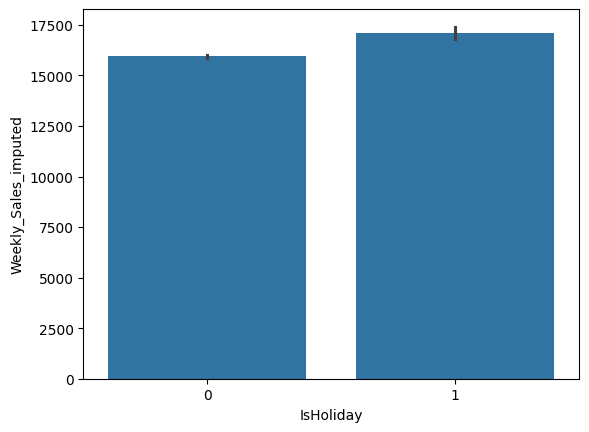

In [316]:
# review the Holiday column
import seaborn as sns
sns.barplot(x='IsHoliday', y='Weekly_Sales_imputed', data= df_train_merged)

In [282]:
# Review the Size - type relation

df_train_merged.groupby('Type').describe()['Size_imputed'].round(2)

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,214961.0,182225.39,41532.66,39690.0,158114.0,202505.0,203819.0,219622.0
B,162787.0,101796.84,30944.31,34875.0,93188.0,114533.0,123737.0,140167.0
C,42464.0,40536.10,1194.69,39690.0,39690.0,39910.0,41062.0,42988.0


In [283]:
# Clean the data frame

df_train_merged.isna().sum()




Store                   0
Date                    0
Dept                    0
Weekly_Sales_imputed    0
Temperature             0
Fuel_Price              0
MarkDown1_imputed       0
MarkDown2_imputed       0
MarkDown3_imputed       0
MarkDown4_imputed       0
MarkDown5_imputed       0
CPI_imputed             0
Unemployment_imputed    0
Type                    0
Size_imputed            0
scaled_features         0
IsHoliday               0
dtype: int64

In [284]:
# review the statistical measures

df_train_merged.describe()

,Store,Dept,Weekly_Sales_imputed,Temperature,Fuel_Price,MarkDown1_imputed,MarkDown2_imputed,MarkDown3_imputed,MarkDown4_imputed,MarkDown5_imputed,CPI_imputed,Unemployment_imputed,Size_imputed,IsHoliday
count,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000
mean,22.195611,44.241309,16033.114591,60.090599,3.360890,7109.372559,3369.917236,1656.569336,3322.337646,4310.838379,171.212494,7.960001,136749.732787,0.070345
std,12.787236,30.508819,22729.492116,18.447857,0.458519,4958.834961,4860.180664,5494.728027,3561.979980,3579.947266,39.162445,1.863879,60993.084568,0.255729
min,1.000000,1.000000,0.010000,-2.060000,2.472000,0.270000,-265.760010,-29.100000,0.220000,135.160004,126.064003,3.879000,34875.000000,0.000000
25%,11.000000,18.000000,2120.130000,46.680000,2.933000,7032.371582,3384.176514,115.389999,3292.935791,4132.216309,132.022659,6.891000,93638.000000,0.000000
50%,22.000000,37.000000,7661.700000,62.090000,3.452000,7032.371582,3384.176514,1760.100220,3292.935791,4132.216309,182.350983,7.866000,140167.000000,0.000000
75%,33.000000,74.000000,20271.265000,74.280000,3.738000,7032.371582,3384.176514,1760.100220,3292.935791,4132.216309,212.445480,8.567000,202505.000000,0.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.757812,104519.539062,141630.609375,67474.851562,108519.281250,227.232803,14.313000,219622.000000,1.000000


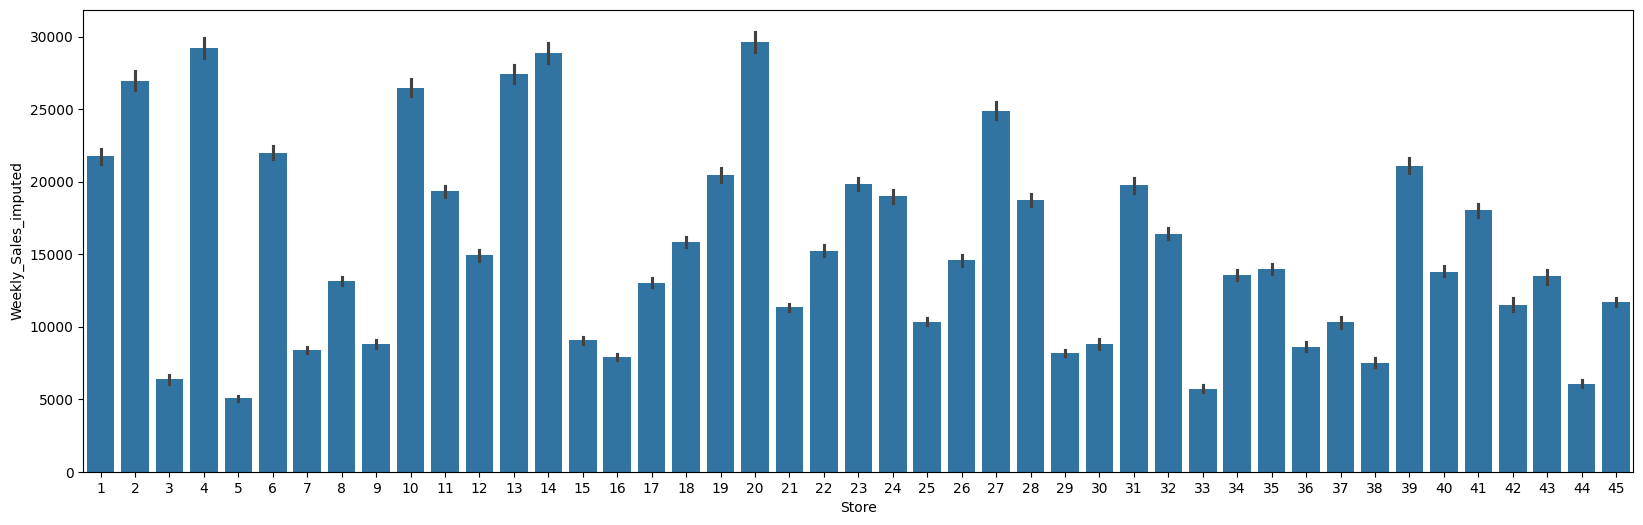

In [253]:
# Review the sales by Stores

plt.figure(figsize=(20,6))
Stores_fg = sns.barplot(x='Store', y='Weekly_Sales_imputed', data= df_train_merged)

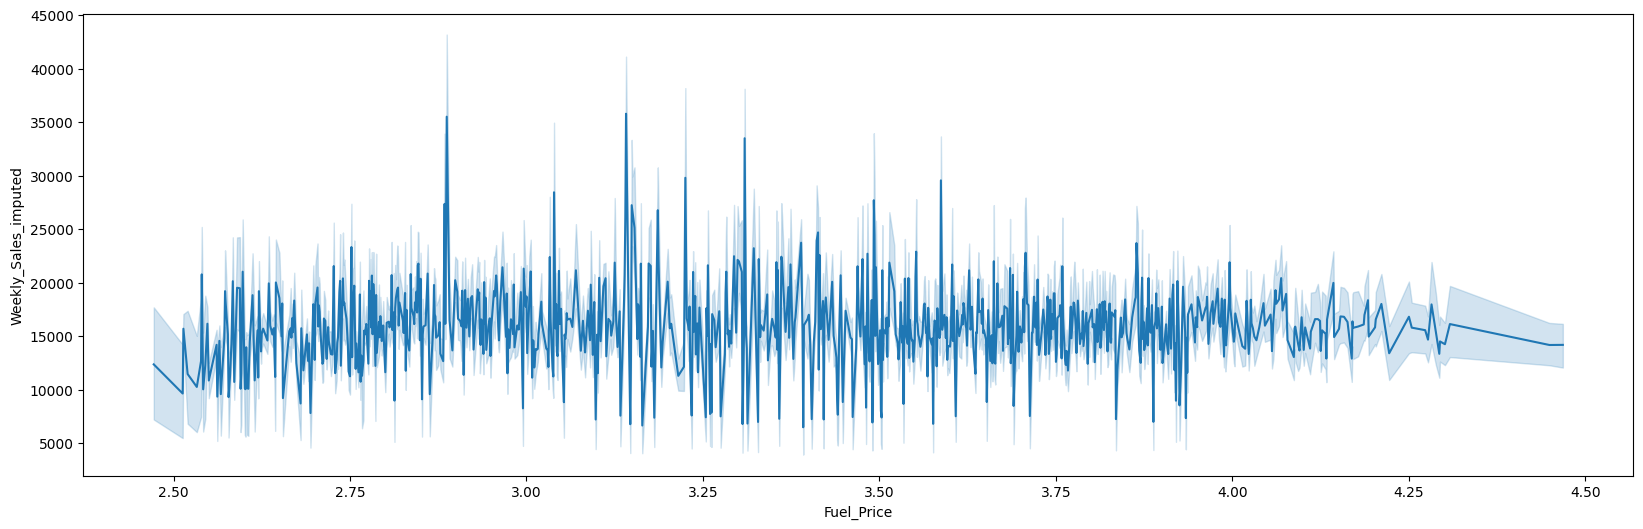

In [194]:
# Review the Fuel Price relation vs WK sales
plt.figure(figsize=(20,6))
fuel_price = sns.lineplot(x='Fuel_Price', y='Weekly_Sales_imputed', data=df_train_merged)


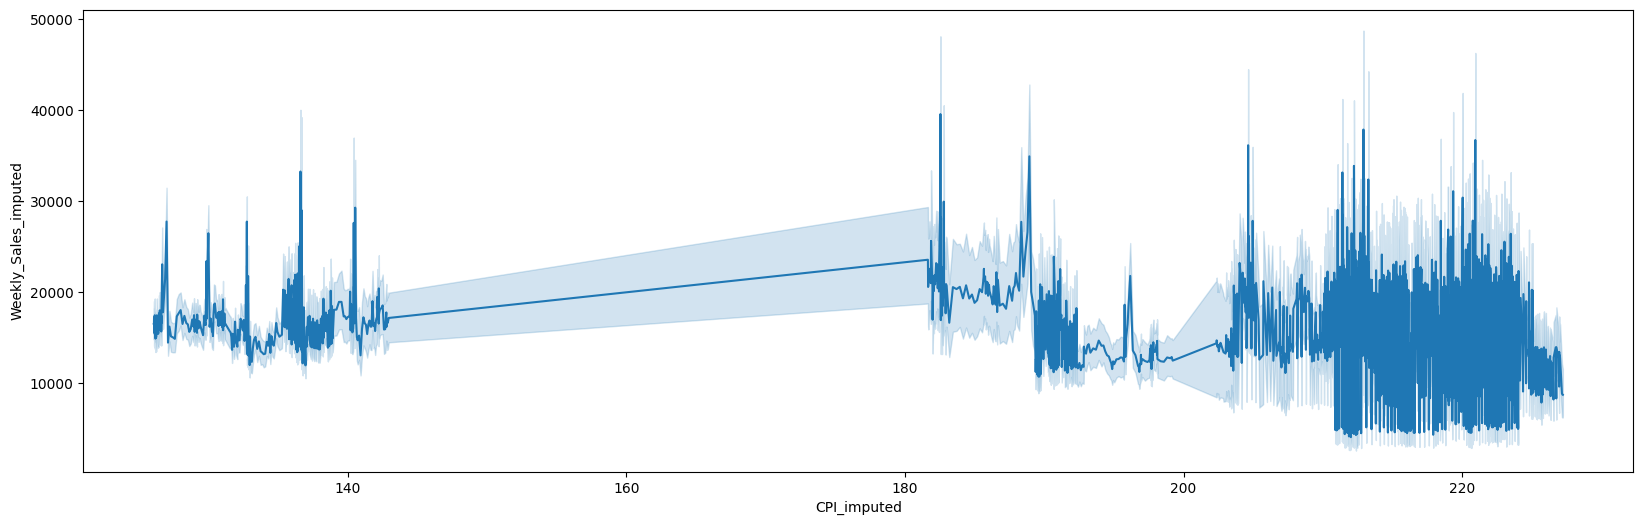

In [195]:
# Review the CPI vs WK Sales
plt.figure(figsize=(20,6))
CPI_plot = sns.lineplot(x='CPI_imputed', y='Weekly_Sales_imputed', data=df_train_merged)



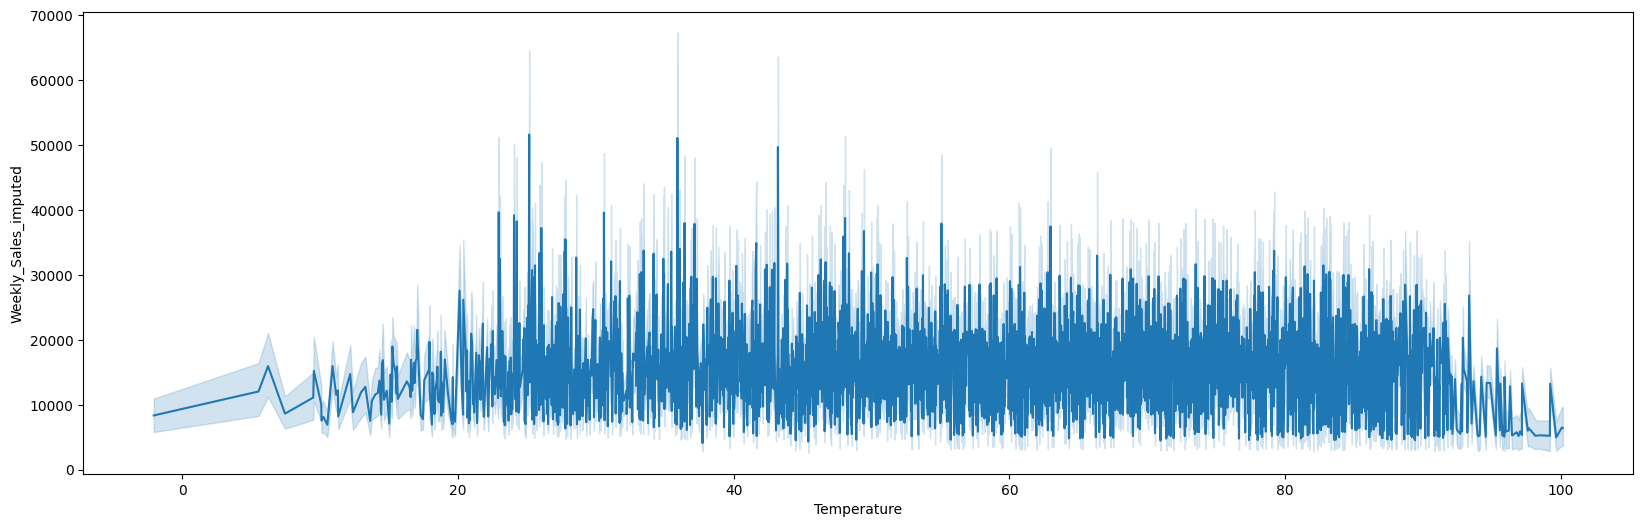

In [196]:
# Review the Temperature vs WK Sales
plt.figure(figsize=(20,6))
Temp_plot = sns.lineplot(x='Temperature', y='Weekly_Sales_imputed', data=df_train_merged)

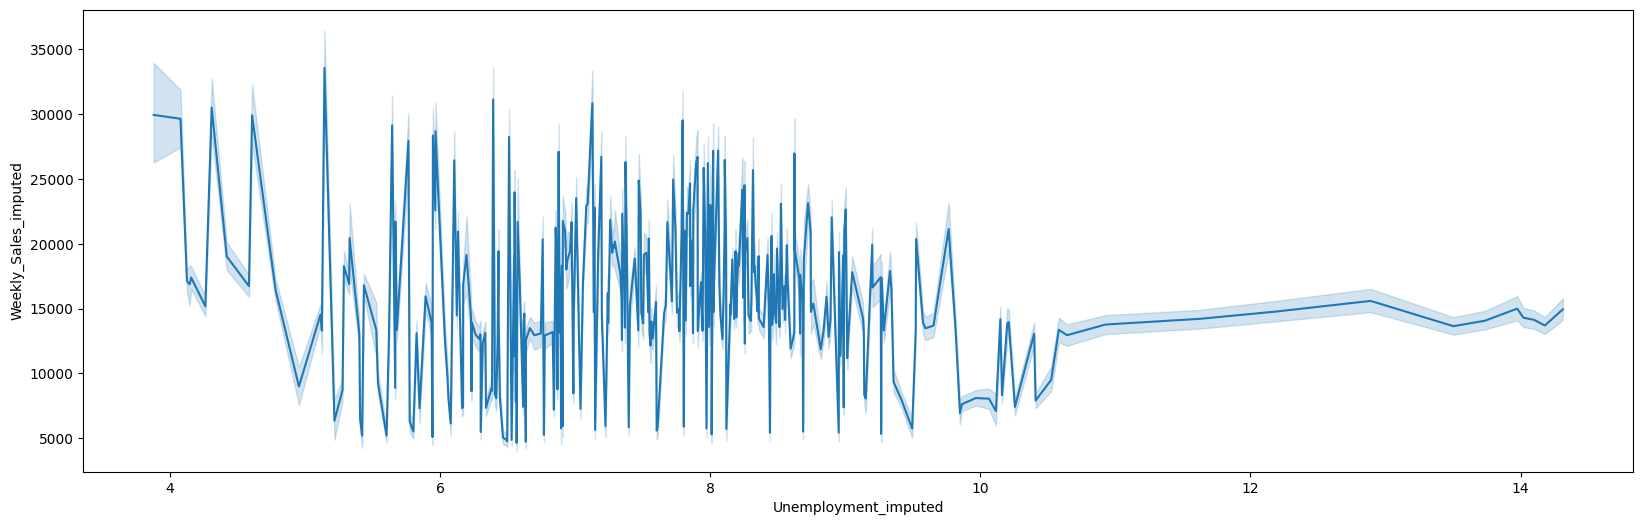

In [197]:
# Review the Unemployment vs WK Sales
plt.figure(figsize=(20,6))
Temp_plot = sns.lineplot(x='Unemployment_imputed', y='Weekly_Sales_imputed', data=df_train_merged)

<ipython-input-254-b568e20c3c2f>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_train_merged.corr().abs())


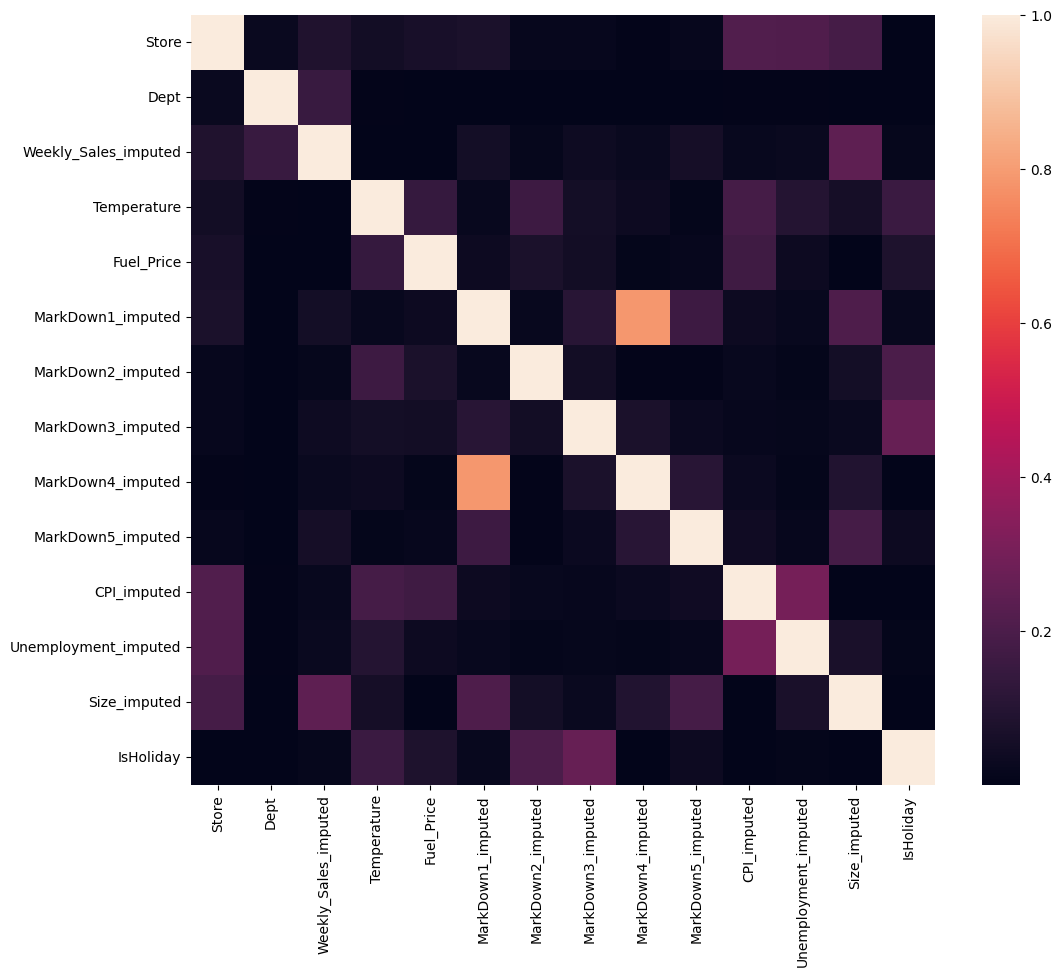

In [254]:
# Review the correlation with all the columns

plt.figure(figsize=(12,10))
sns.heatmap(df_train_merged.corr().abs())
plt.show()


In [199]:
# We can identify that the correlation between WK Sales and all the columns except Store, Dept, Type and Size are insignifcatn


In [285]:
# Drop columns with any relation

drop_columns= ['Date','scaled_features','Temperature','Fuel_Price','MarkDown1_imputed','MarkDown2_imputed','MarkDown3_imputed','MarkDown4_imputed','MarkDown5_imputed','CPI_imputed','Unemployment_imputed','Type']
df_train_merged.drop(drop_columns, axis=1, inplace=True)


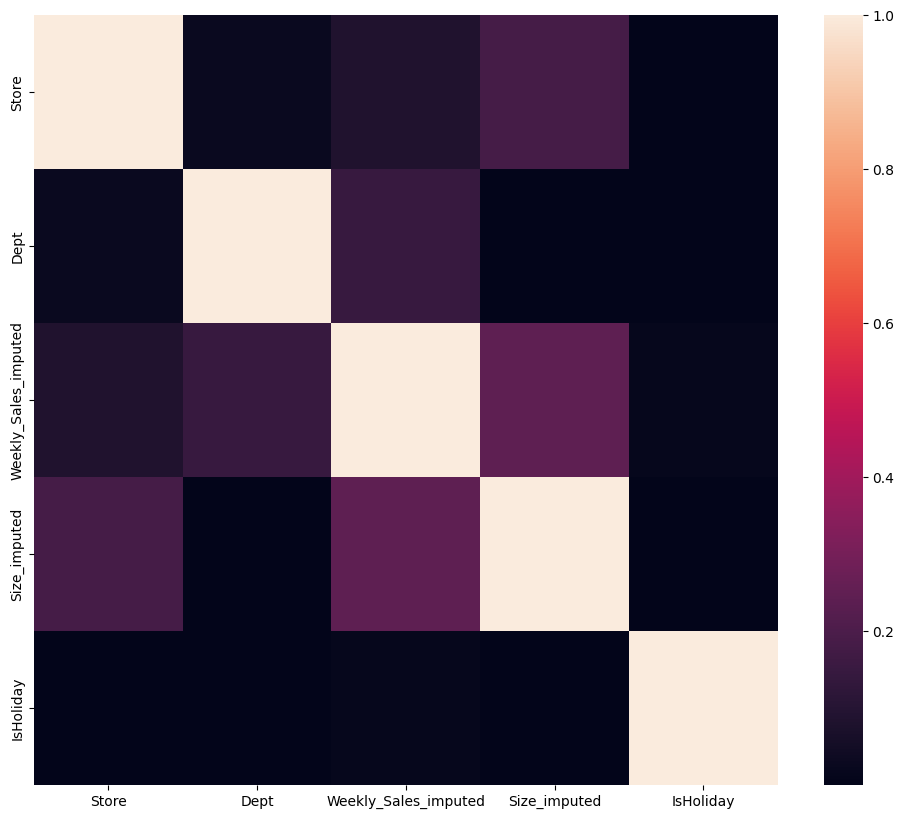

In [286]:
#review the correlation without the dropping columns
plt.figure(figsize=(12,10))
sns.heatmap(df_train_merged.corr().abs())
plt.show()

In [287]:
#Define features (X) from the Target (y)
#in this case our X is the date  and the y is the weekly Sales
target = 'Weekly_Sales_imputed'

X= [c for c in df_train_merged.columns.tolist() if c not in [target]]
y= df_train_merged['Weekly_Sales_imputed']




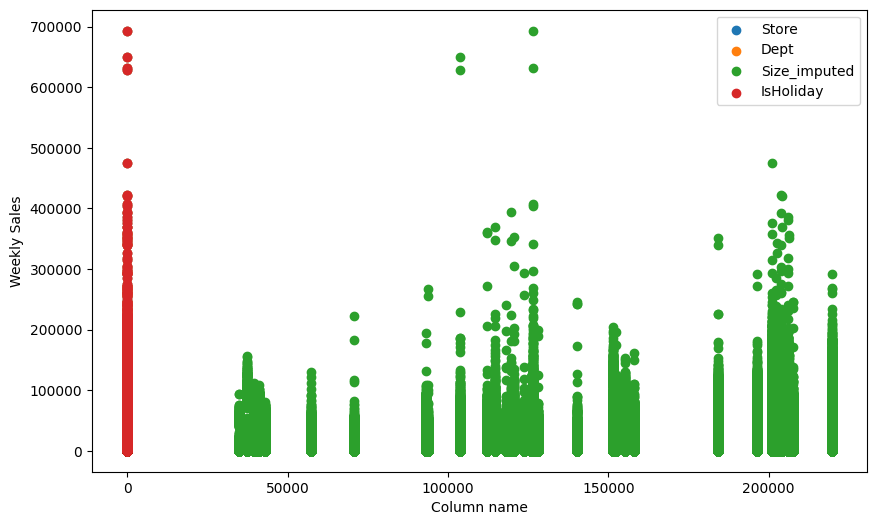

In [288]:
# Matplot of actual data
import matplotlib.pyplot as plt
plt.figure(figsize=[10, 6])
for column_name in X:
    plt.scatter(df_train_merged[column_name], y, label=column_name)

plt.xlabel('Column name')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

In [260]:
# Use sklearn to split dataset
from sklearn.model_selection import train_test_split

X= df_train_merged['Store']


X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=10)

In [262]:
#reshape all the variables
y_train = y_train.to_numpy().reshape(-1,1)
X_train = X_train.to_numpy().reshape(-1,1)

X_test = X_test.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)

In [263]:
#Create a Logistic Regression Model

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [264]:
# Score the model using the test data

model.score(X_test, y_test)

#due to the result this is not a good model


0.006920549172561574

In [271]:
from sklearn.model_selection import train_test_split

X= df_train_merged['Dept']


X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=10)

In [272]:
#reshape all the variables
y_train = y_train.to_numpy().reshape(-1,1)
X_train = X_train.to_numpy().reshape(-1,1)

X_test = X_test.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)

In [273]:
#Create a Logistic Regression Model with Department variable


from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [274]:
from sklearn.model_selection import train_test_split

X= df_train_merged['Size_imputed']


X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=10)

In [275]:
#reshape all the variables
y_train = y_train.to_numpy().reshape(-1,1)
X_train = X_train.to_numpy().reshape(-1,1)

X_test = X_test.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)

In [276]:
# Score the model using the test data for Size variable

model.score(X_test, y_test)

#due to the result this is not a good model

-529272.7801967312

In [289]:
from sklearn.model_selection import train_test_split

X= df_train_merged['IsHoliday']


X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=10)

In [290]:
#reshape all the variables
y_train = y_train.to_numpy().reshape(-1,1)
X_train = X_train.to_numpy().reshape(-1,1)

X_test = X_test.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)

In [291]:
# Score the model using the test data for Size variable

model.score(X_test, y_test)

#due to the result this is not a good model

-0.04729459748538911

In [296]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Split the dataset into features (X) and target variable (y)
X = df_train_merged['IsHoliday']
y =   df_train_merged['Weekly_Sales_imputed']


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [297]:
#reshape all the variables
y_train = y_train.to_numpy().reshape(-1,1)
X_train = X_train.to_numpy().reshape(-1,1)

X_test = X_test.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)

In [298]:
import numpy as np

# Initialize and train the Random Forest Regressor model

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the testing data
predictions = rf_model.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

<ipython-input-298-8381a269bc99>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Mean Squared Error: 502334778.7331643


<ipython-input-300-a179361473f8>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--', lw=2, color='red', label='Ideal Line')


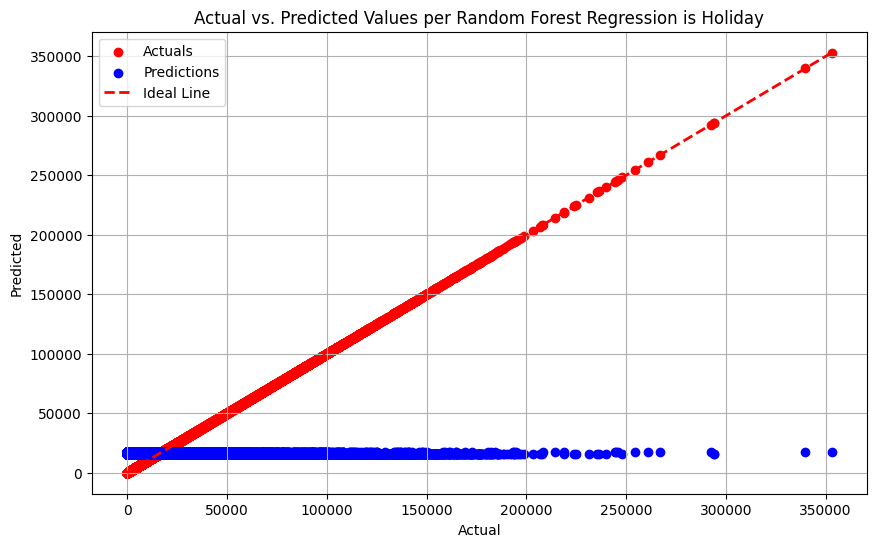

In [300]:
import numpy as np

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test, color='red', label='Actuals')  # Plotting y_test against itself just for demonstration
plt.scatter(y_test, predictions, color='blue', label='Predictions')
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--', lw=2, color='red', label='Ideal Line')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values per Random Forest Regression is Holiday')
plt.legend()
plt.grid(True)
plt.show()


In [301]:
# Split the dataset into features (X) and target variable (y)
X = df_train_merged['Dept']
y =   df_train_merged['Weekly_Sales_imputed']


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#reshape all the variables
y_train = y_train.to_numpy().reshape(-1,1)
X_train = X_train.to_numpy().reshape(-1,1)

X_test = X_test.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)
# Initialize and train the Random Forest Regressor model

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the testing data
predictions = rf_model.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

<ipython-input-301-ce3a3c9984d3>:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Mean Squared Error: 228757195.37063012


<ipython-input-302-a48c889fcc45>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--', lw=2, color='red', label='Ideal Line')


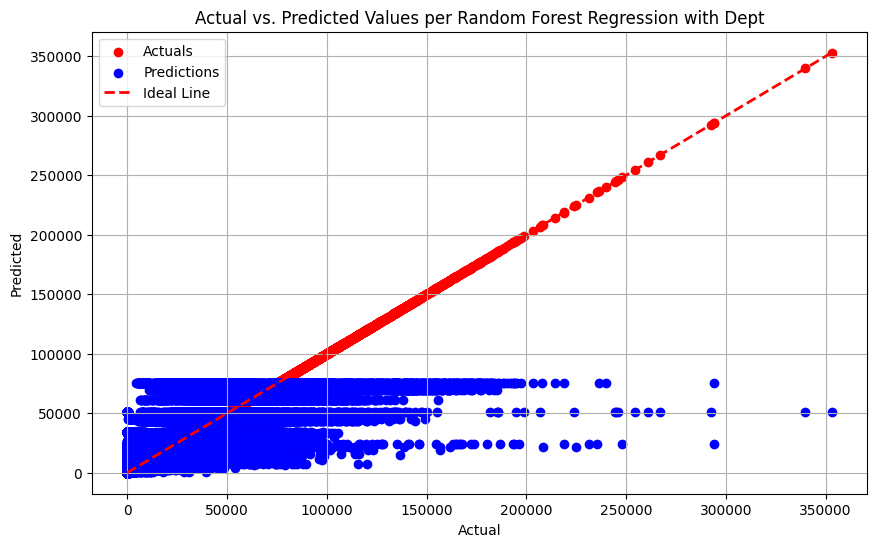

In [302]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test, color='red', label='Actuals')  # Plotting y_test against itself just for demonstration
plt.scatter(y_test, predictions, color='blue', label='Predictions')
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--', lw=2, color='red', label='Ideal Line')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values per Random Forest Regression with Dept')
plt.legend()
plt.grid(True)
plt.show()

In [303]:
# Split the dataset into features (X) and target variable (y)
X = df_train_merged['Size_imputed']
y =   df_train_merged['Weekly_Sales_imputed']


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#reshape all the variables
y_train = y_train.to_numpy().reshape(-1,1)
X_train = X_train.to_numpy().reshape(-1,1)

X_test = X_test.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)
# Initialize and train the Random Forest Regressor model

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the testing data
predictions = rf_model.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

<ipython-input-303-554a7188f39c>:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Mean Squared Error: 456711653.0911107


<ipython-input-304-fb1634111f61>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--', lw=2, color='red', label='Ideal Line')


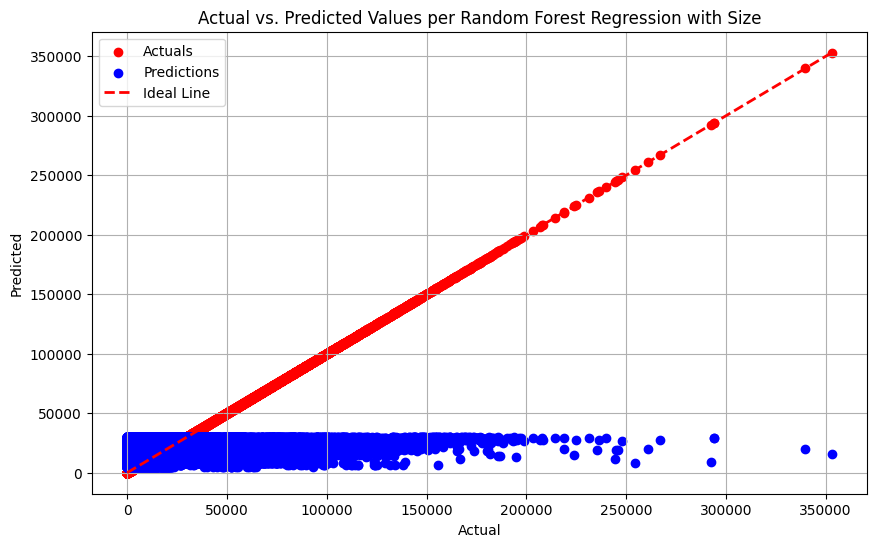

In [304]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test, color='red', label='Actuals')  # Plotting y_test against itself just for demonstration
plt.scatter(y_test, predictions, color='blue', label='Predictions')
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--', lw=2, color='red', label='Ideal Line')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values per Random Forest Regression with Size')
plt.legend()
plt.grid(True)
plt.show()

In [305]:
# Split the dataset into features (X) and target variable (y)
X = df_train_merged['Store']
y =   df_train_merged['Weekly_Sales_imputed']


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#reshape all the variables
y_train = y_train.to_numpy().reshape(-1,1)
X_train = X_train.to_numpy().reshape(-1,1)

X_test = X_test.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)
# Initialize and train the Random Forest Regressor model

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the testing data
predictions = rf_model.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

<ipython-input-305-efc7ff59c996>:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Mean Squared Error: 456222361.106834


<ipython-input-306-f01c4d87bf92>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--', lw=2, color='red', label='Ideal Line')


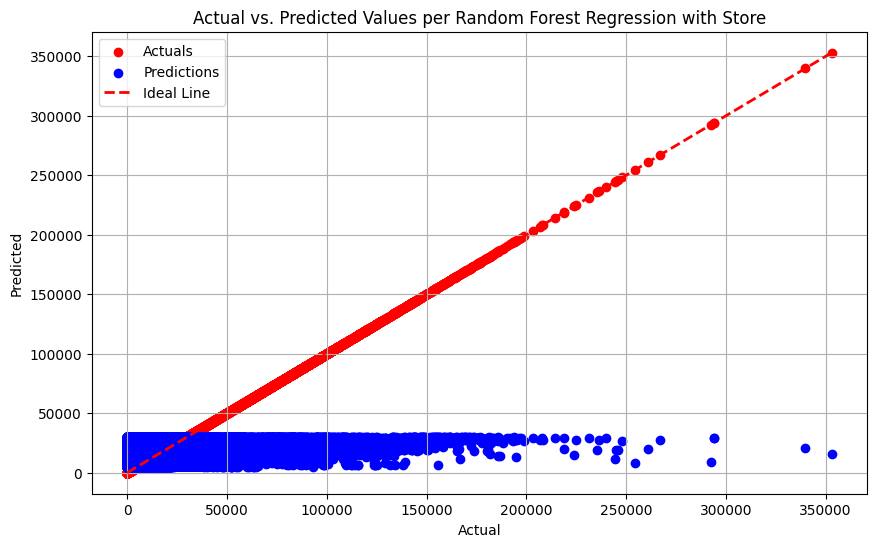

In [306]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test, color='red', label='Actuals')  # Plotting y_test against itself just for demonstration
plt.scatter(y_test, predictions, color='blue', label='Predictions')
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--', lw=2, color='red', label='Ideal Line')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values per Random Forest Regression with Store')
plt.legend()
plt.grid(True)
plt.show()

In [313]:
# According with the results, neither Lineal Regression nor Random Regression give us a good result, we research for the model used originally, calculating...
def wmae_test(test, pred):
    weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

In [314]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline
scaler = RobustScaler()



#making pipe tp use scaler and regressor together
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train, y_train)

# predictions on train set
y_pred = pipe.predict(X_train)

# predictions on test set
y_pred_test = pipe.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


In [ ]:
X_test = pd.DataFrame(index=y_test.index)

In [ ]:
wmae_test(y_test, y_pred_test)

In [318]:
# Create dataframe to analize the info in Tableau
#path = '/content/'
df_train_merged.to_csv('Weekly sales trained.csv')



In [319]:
spark.stop()